In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical


C:\Users\mainf\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
input_dir = 'archive (18)/Data'
categories = ['glioma_tumor','meningioma_tumor','normal','pituitary_tumor']

data = []
labels = []

for category_idx,category in enumerate(categories):
    for file in os.listdir(os.path.join(input_dir,category)):
        img_path = os.path.join(input_dir,category,file)
        img = imread(img_path)
        img = resize(img,(15,15))
        data.append(img.flatten())
        labels.append(category_idx)
        

In [3]:
number_classes = {
    'glioma_tumor': len(os.listdir('archive (18)/Data/glioma_tumor')),
    'meningioma_tumor': len(os.listdir('archive (18)/Data/meningioma_tumor')),
    'normal': len(os.listdir('archive (18)/Data/normal')),
    'pituitary_tumor': len(os.listdir('archive (18)/Data/pituitary_tumor'))
}

In [4]:
number_classes

{'glioma_tumor': 901,
 'meningioma_tumor': 913,
 'normal': 438,
 'pituitary_tumor': 844}

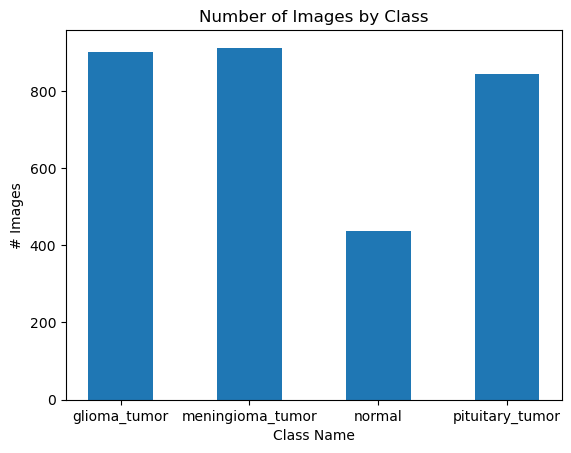

In [5]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

In [6]:
from PIL import Image
import dask.bag as bag
from dask import diagnostics


In [7]:
directories = {
    'glioma_tumor': 'archive (18)/Data/glioma_tumor',
    'meningioma_tumor': 'archive (18)/Data/meningioma_tumor',
    'normal': 'archive (18)/Data/normal',
    'pituitary_tumor': 'archive (18)/Data/pituitary_tumor'
}

def get_dims(file):

    '''Returns dimenstions for an RBG image'''
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

In [8]:
get_dims('archive (18)/Data/glioma_tumor/G_1.jpg')

(256, 256)

901
[########################################] | 100% Completed | 1.85 ss
913
[########################################] | 100% Completed | 2.05 ss
438
[########################################] | 100% Completed | 1.74 ss
844
[########################################] | 100% Completed | 2.05 ss


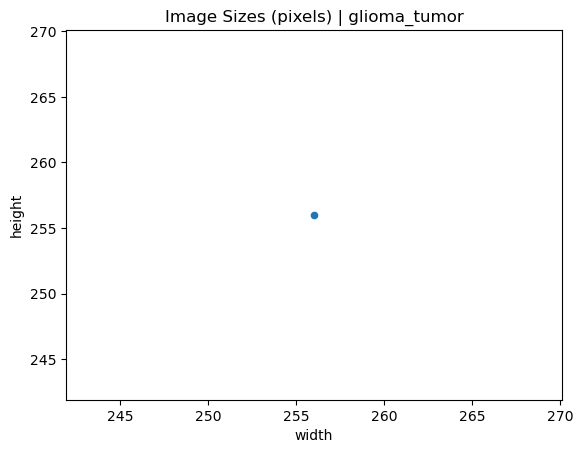

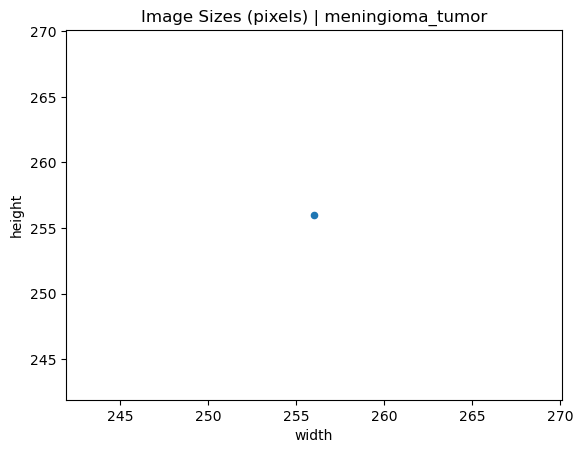

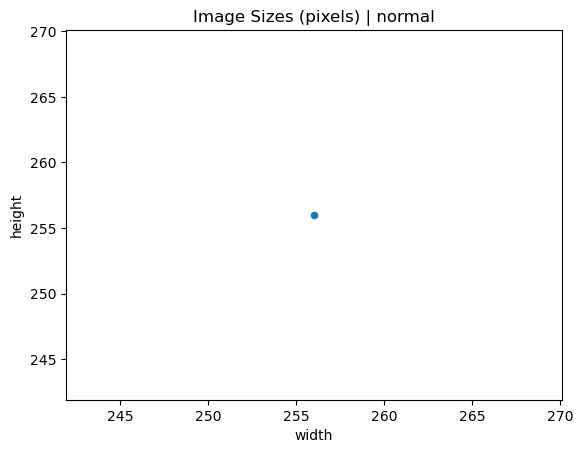

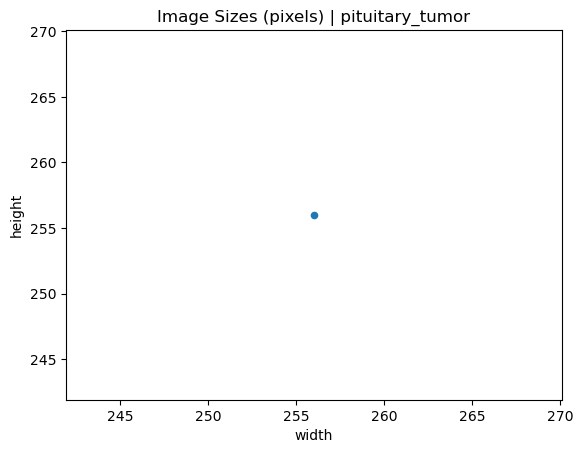

In [9]:
for n,d in directories.items():
    filepath = d
    filelist = [os.path.join(filepath, f) for f in os.listdir(filepath)]
    print(len(filelist))
    dims = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(n))

In [10]:
data = np.asarray(data)
labels = np.asarray(labels)

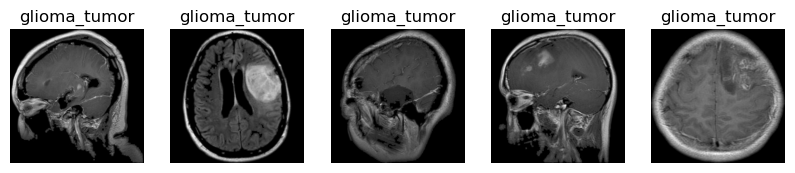

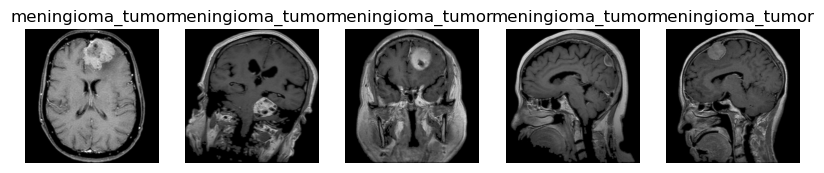

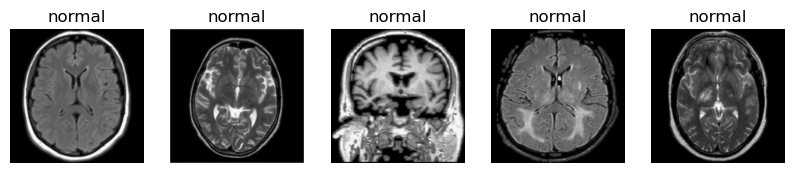

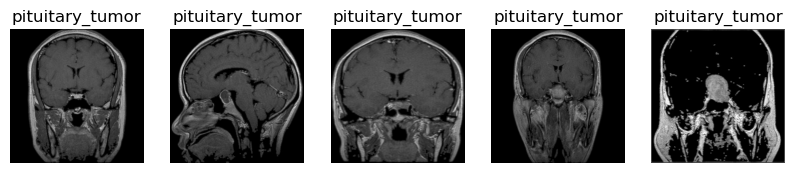

In [11]:
import random
from PIL import Image
for i in directories.values():
    image_files = os.listdir(i) 
    sampled_images = random.sample(image_files, 5)


    plt.figure(figsize=(10, 10)) 
    for j, image_file in enumerate(sampled_images):
        img = Image.open(os.path.join(i, image_file))
        plt.subplot(1, 5, j + 1)
        plt.imshow(img)
        plt.axis('off')
        parts = i.split('/')
        plt.title(parts[-1])
plt.show()


In [12]:
#What can I do about the different angles that photos are taken from?

In [13]:
data

array([[1.29676122e-12, 1.29676122e-12, 1.29676122e-12, ...,
        1.74988130e-05, 1.74988130e-05, 1.74988130e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.33767273e-12, 1.33767273e-12, 1.33767273e-12],
       [4.22922865e-14, 4.22922865e-14, 4.22922865e-14, ...,
        4.41609308e-09, 4.41609308e-09, 4.41609308e-09],
       ...,
       [3.82682482e-09, 3.82682482e-09, 3.82682482e-09, ...,
        4.71911205e-05, 4.71911205e-05, 4.71911205e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.41258522e-03, 1.41258522e-03, 1.41258522e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.61911932e-04, 1.61911932e-04, 1.61911932e-04]])

In [14]:
len(data)

3096

In [15]:
len(labels) 

3096

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=.2,stratify=labels,shuffle=True,random_state=123)

In [17]:
classifier = SVC()

parameters = [{'gamma': [0.01,0.001,0.0001],'C':[1,10,100,1000]}]

grid_search = GridSearchCV(classifier, parameters)

grid_search.fit(X_train,y_train)
best_model = grid_search.best_estimator_

In [18]:
y_preds_svc = best_model.predict(X_test)
print(classification_report(y_test,y_preds_svc))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       180
           1       0.84      0.80      0.82       183
           2       0.88      0.88      0.88        88
           3       0.90      0.93      0.92       169

    accuracy                           0.86       620
   macro avg       0.86      0.86      0.86       620
weighted avg       0.86      0.86      0.86       620



In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

#Keras is simplier to use 
#Pytorch is more "Pythonic"
#Tenosr flow is the most complex to learn



In [20]:
print(X_train.shape)


(2476, 675)


In [21]:
from keras.models import Sequential
from keras.layers import Dense

In [22]:
model = Sequential()
model.add(Dense(600, input_shape=(675,), activation='relu'))  
model.add(Dense(300, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
model.fit(X_train,y_train,epochs=100)
y_preds = model.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)

print(classification_report(y_test,class_predictions))

Epoch 1/100


78/78 [==============================] - 1s 4ms/step - loss: 1.2780 - accuracy: 0.4083
Epoch 2/100
78/78 [==============================] - 0s 4ms/step - loss: 1.0901 - accuracy: 0.5327
Epoch 3/100
78/78 [==============================] - 0s 4ms/step - loss: 0.9936 - accuracy: 0.5670
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.9317 - accuracy: 0.6014
Epoch 5/100
78/78 [==============================] - 0s 4ms/step - loss: 0.8430 - accuracy: 0.6454
Epoch 6/100
78/78 [==============================] - 0s 4ms/step - loss: 0.8403 - accuracy: 0.6579
Epoch 7/100
78/78 [==============================] - 0s 4ms/step - loss: 0.7979 - accuracy: 0.6664
Epoch 8/100
78/78 [==============================] - 0s 4ms/step - loss: 0.7740 - accuracy: 0.6737
Epoch 9/100
78/78 [==============================] - 0s 4ms/step - loss: 0.7492 - accuracy: 0.7023
Epoch 10/100
78/78 [==============================] - 0s 5ms/step - loss: 0.7269 - accuracy: 0.7052
Epoch 1

78/78 [==============================] - 0s 5ms/step - loss: 0.0360 - accuracy: 0.9883
Epoch 79/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0581 - accuracy: 0.9778
Epoch 80/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0478 - accuracy: 0.9822
Epoch 81/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0536 - accuracy: 0.9818
Epoch 82/100
78/78 [==============================] - 0s 5ms/step - loss: 0.1421 - accuracy: 0.9499
Epoch 83/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0958 - accuracy: 0.9632
Epoch 84/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0348 - accuracy: 0.9883
Epoch 85/100
78/78 [==============================] - 0s 4ms/step - loss: 0.1068 - accuracy: 0.9624
Epoch 86/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0968 - accuracy: 0.9645
Epoch 87/100
78/78 [==============================] - 0s 5ms/step - loss: 0.1492 - accuracy: 0.9435
Epoch 88/100


In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='min')
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0849 - accuracy: 0.9709 - val_loss: 0.7472 - val_accuracy: 0.8403
Epoch 2/100
22/78 [=======>......................] - ETA: 0s - loss: 0.0671 - accuracy: 0.9759

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 6ms/step - loss: 0.0529 - accuracy: 0.9790 - val_loss: 0.7058 - val_accuracy: 0.8726
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.7074 - val_accuracy: 0.8871
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.7439 - val_accuracy: 0.8871
Epoch 5/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0052 - accuracy: 0.9980 - val_loss: 0.7465 - val_accuracy: 0.8806
Epoch 6/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0049 - accuracy: 0.9980 - val_loss: 0.7854 - val_accuracy: 0.8823
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.8033 - val_accuracy: 0.8726
Epoch 8/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.7886 - val_accuracy: 0.8790
Epoch 9/100
78/78 [======

Epoch 23/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.7572 - val_accuracy: 0.8871
Epoch 24/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9980 - val_loss: 0.7733 - val_accuracy: 0.8887
Epoch 25/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.7832 - val_accuracy: 0.8887
Epoch 26/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.7641 - val_accuracy: 0.9000
Epoch 26: early stopping
20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       180
           1       0.89      0.89      0.89       183
           2       0.94      0.89      0.91        88
           3       0.89      0.95      0.92       169

    accuracy                           0.90       620
   macro avg       0.91     

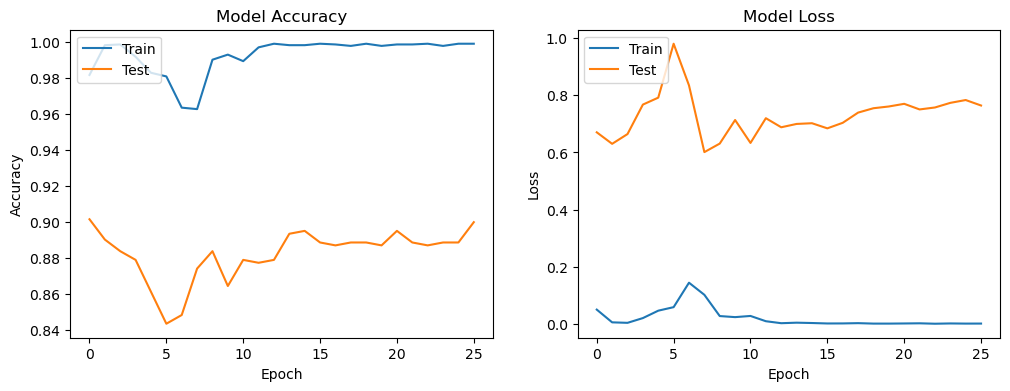

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [26]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout

In [27]:
model2 = Sequential()
model2.add(Dense(600, input_shape=(675,), activation='relu'))
model2.add(Dropout(.05))
model2.add(Dense(300, activation='relu'))
model2.add(Dropout(.05))
model2.add(Dense(150, activation='relu'))
model2.add(Dense(75, activation='relu'))
model2.add(Dropout(.05))
model2.add(Dense(4, activation='softmax'))




model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [28]:
checkpoint = ModelCheckpoint('model_2.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
model2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history2 = model2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model2.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 1s 8ms/step - loss: 1.2979 - accuracy: 0.3768 - val_loss: 1.1692 - val_accuracy: 0.4274
Epoch 2/100
33/78 [===========>..................] - ETA: 0s - loss: 1.1710 - accuracy: 0.4536

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 6ms/step - loss: 1.1460 - accuracy: 0.4790 - val_loss: 1.0927 - val_accuracy: 0.5000
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0292 - accuracy: 0.5400 - val_loss: 0.9553 - val_accuracy: 0.5629
Epoch 4/100
78/78 [==============================] - 1s 7ms/step - loss: 0.9426 - accuracy: 0.5981 - val_loss: 1.1391 - val_accuracy: 0.4871
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9807 - accuracy: 0.5804 - val_loss: 0.8983 - val_accuracy: 0.6194
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9042 - accuracy: 0.6216 - val_loss: 0.9040 - val_accuracy: 0.6048
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8365 - accuracy: 0.6494 - val_loss: 0.8750 - val_accuracy: 0.6290
Epoch 8/100
78/78 [==============================] - 1s 6ms/step - loss: 0.8213 - accuracy: 0.6616 - val_loss: 0.7652 - val_accuracy: 0.6677
Epoch 9/100
78/78 [======

Epoch 60/100
78/78 [==============================] - 0s 6ms/step - loss: 0.2198 - accuracy: 0.9140 - val_loss: 0.5939 - val_accuracy: 0.8403
Epoch 61/100
78/78 [==============================] - 0s 6ms/step - loss: 0.1863 - accuracy: 0.9249 - val_loss: 0.6155 - val_accuracy: 0.8355
Epoch 62/100
78/78 [==============================] - 0s 6ms/step - loss: 0.2298 - accuracy: 0.9144 - val_loss: 0.6239 - val_accuracy: 0.8339
Epoch 63/100
78/78 [==============================] - 0s 6ms/step - loss: 0.2055 - accuracy: 0.9241 - val_loss: 0.5582 - val_accuracy: 0.8306
Epoch 64/100
78/78 [==============================] - 1s 7ms/step - loss: 0.1788 - accuracy: 0.9338 - val_loss: 0.6522 - val_accuracy: 0.8048
Epoch 65/100
78/78 [==============================] - 0s 6ms/step - loss: 0.2069 - accuracy: 0.9229 - val_loss: 0.6971 - val_accuracy: 0.7839
Epoch 66/100
78/78 [==============================] - 0s 6ms/step - loss: 0.2173 - accuracy: 0.9148 - val_loss: 0.6164 - val_accuracy: 0.8435
Epoch 

78/78 [==============================] - 0s 6ms/step - loss: 0.0790 - accuracy: 0.9742 - val_loss: 0.7223 - val_accuracy: 0.8677
Epoch 31/100
78/78 [==============================] - 1s 7ms/step - loss: 0.0656 - accuracy: 0.9774 - val_loss: 0.7472 - val_accuracy: 0.8597
Epoch 32/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0776 - accuracy: 0.9701 - val_loss: 0.7968 - val_accuracy: 0.8500
Epoch 33/100
78/78 [==============================] - 1s 7ms/step - loss: 0.0995 - accuracy: 0.9689 - val_loss: 0.6930 - val_accuracy: 0.8677
Epoch 34/100
78/78 [==============================] - 0s 6ms/step - loss: 0.1149 - accuracy: 0.9592 - val_loss: 0.8201 - val_accuracy: 0.8629
Epoch 35/100
78/78 [==============================] - 0s 6ms/step - loss: 0.1258 - accuracy: 0.9544 - val_loss: 0.6342 - val_accuracy: 0.8597
Epoch 36/100
78/78 [==============================] - 0s 6ms/step - loss: 0.1375 - accuracy: 0.9540 - val_loss: 0.5847 - val_accuracy: 0.8500
Epoch 37/100
78/78 

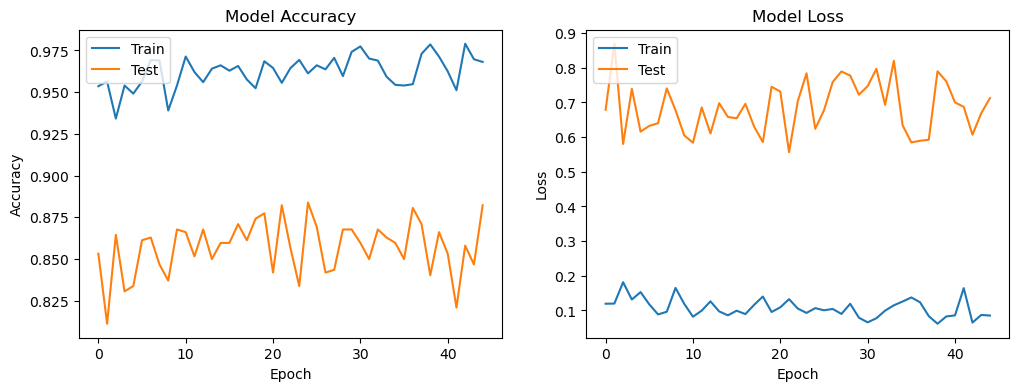

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [30]:
model3 = Sequential()
   
model3.add(Dense(600, input_shape=(675,), activation='relu',kernel_regularizer=l2(0.01),  
                bias_regularizer=l1(0.01)))  
model3.add(Dense(300, activation='relu',kernel_regularizer=l2(0.01),  
                bias_regularizer=l1(0.01)))
model3.add(Dense(150, activation='relu',kernel_regularizer=l2(0.01),  
                bias_regularizer=l1(0.01)))
model3.add(Dense(75, activation='relu'))
model3.add(Dense(4, activation='softmax'))

model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [31]:

early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
model3.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history3 = model3.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model3.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 1s 7ms/step - loss: 5.6256 - accuracy: 0.3518 - val_loss: 2.0678 - val_accuracy: 0.3935
Epoch 2/100
78/78 [==============================] - 0s 5ms/step - loss: 1.6461 - accuracy: 0.4309 - val_loss: 1.4218 - val_accuracy: 0.3806
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3484 - accuracy: 0.4879 - val_loss: 1.2088 - val_accuracy: 0.5597
Epoch 4/100
78/78 [==============================] - 0s 5ms/step - loss: 1.2768 - accuracy: 0.4984 - val_loss: 1.4108 - val_accuracy: 0.3661
Epoch 5/100
78/78 [==============================] - 0s 5ms/step - loss: 1.2349 - accuracy: 0.5279 - val_loss: 1.1554 - val_accuracy: 0.5758
Epoch 6/100
78/78 [==============================] - 0s 5ms/step - loss: 1.1860 - accuracy: 0.5452 - val_loss: 1.1642 - val_accuracy: 0.5742
Epoch 7/100
78/78 [==============================] - 0s 5ms/step - loss: 1.1590 - accuracy: 0.5525 - val_loss: 1.1082 - val_accuracy: 0.6065
Epoch 8/100
7

Epoch 59/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8137 - accuracy: 0.7569 - val_loss: 0.8070 - val_accuracy: 0.7839
Epoch 60/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7954 - accuracy: 0.7690 - val_loss: 0.8499 - val_accuracy: 0.7823
Epoch 61/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8354 - accuracy: 0.7431 - val_loss: 1.0710 - val_accuracy: 0.6677
Epoch 62/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8211 - accuracy: 0.7540 - val_loss: 0.8933 - val_accuracy: 0.7565
Epoch 63/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8389 - accuracy: 0.7435 - val_loss: 0.9317 - val_accuracy: 0.7129
Epoch 64/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8447 - accuracy: 0.7452 - val_loss: 1.1344 - val_accuracy: 0.6387
Epoch 65/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8811 - accuracy: 0.7407 - val_loss: 0.8686 - val_accuracy: 0.7613
Epoch 

78/78 [==============================] - 1s 11ms/step - loss: 0.7547 - accuracy: 0.7948 - val_loss: 0.8604 - val_accuracy: 0.7823
Epoch 41/200
78/78 [==============================] - 1s 7ms/step - loss: 0.7083 - accuracy: 0.8150 - val_loss: 0.8560 - val_accuracy: 0.7710
Epoch 42/200
78/78 [==============================] - 1s 7ms/step - loss: 0.6938 - accuracy: 0.8166 - val_loss: 0.7957 - val_accuracy: 0.8113
Epoch 43/200
78/78 [==============================] - 1s 7ms/step - loss: 0.6570 - accuracy: 0.8348 - val_loss: 0.9535 - val_accuracy: 0.7323
Epoch 44/200
78/78 [==============================] - 0s 6ms/step - loss: 0.6724 - accuracy: 0.8150 - val_loss: 0.8570 - val_accuracy: 0.7645
Epoch 45/200
78/78 [==============================] - 0s 6ms/step - loss: 0.7019 - accuracy: 0.8158 - val_loss: 0.8227 - val_accuracy: 0.8129
Epoch 46/200
78/78 [==============================] - 0s 6ms/step - loss: 0.6659 - accuracy: 0.8267 - val_loss: 1.0792 - val_accuracy: 0.7161
Epoch 47/200
78/78

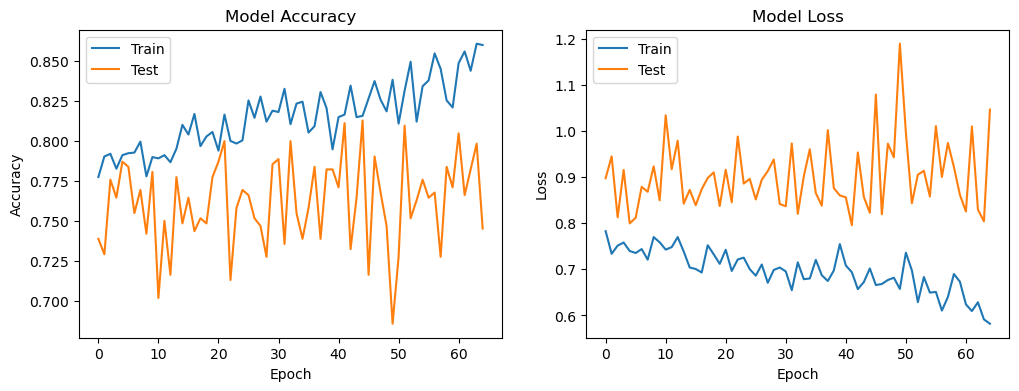

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [33]:
model4 = Sequential()

model4.add(Dense(1000, input_shape=(675,), activation='relu'))
model4.add(Dense(500, activation='relu'))
model4.add(Dense(250, activation='relu'))
model4.add(Dense(4, activation='softmax'))

model4.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
model4.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history4 = model4.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model4.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 2s 13ms/step - loss: 1.2772 - accuracy: 0.3982 - val_loss: 1.1770 - val_accuracy: 0.4887
Epoch 2/100
78/78 [==============================] - 1s 11ms/step - loss: 1.0720 - accuracy: 0.5335 - val_loss: 1.1892 - val_accuracy: 0.4129
Epoch 3/100
78/78 [==============================] - 1s 11ms/step - loss: 0.9896 - accuracy: 0.5626 - val_loss: 0.9159 - val_accuracy: 0.6032
Epoch 4/100
78/78 [==============================] - 1s 10ms/step - loss: 0.9170 - accuracy: 0.6038 - val_loss: 0.8314 - val_accuracy: 0.7016
Epoch 5/100
78/78 [==============================] - 1s 10ms/step - loss: 0.8914 - accuracy: 0.6216 - val_loss: 0.8434 - val_accuracy: 0.6548
Epoch 6/100
78/78 [==============================] - 1s 10ms/step - loss: 0.8597 - accuracy: 0.6454 - val_loss: 0.8997 - val_accuracy: 0.6242
Epoch 7/100
78/78 [==============================] - 1s 10ms/step - loss: 0.7864 - accuracy: 0.6777 - val_loss: 0.8272 - val_accuracy: 0.6387
Epoch 

78/78 [==============================] - 1s 10ms/step - loss: 0.1031 - accuracy: 0.9564 - val_loss: 0.6529 - val_accuracy: 0.8565
Epoch 59/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0850 - accuracy: 0.9697 - val_loss: 0.6370 - val_accuracy: 0.8710
Epoch 60/100
78/78 [==============================] - 1s 10ms/step - loss: 0.1057 - accuracy: 0.9596 - val_loss: 0.7220 - val_accuracy: 0.8516
Epoch 61/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0792 - accuracy: 0.9717 - val_loss: 0.6662 - val_accuracy: 0.8677
Epoch 62/100
78/78 [==============================] - 1s 10ms/step - loss: 0.1797 - accuracy: 0.9354 - val_loss: 0.8408 - val_accuracy: 0.7984
Epoch 63/100
78/78 [==============================] - 1s 10ms/step - loss: 0.1479 - accuracy: 0.9447 - val_loss: 0.6095 - val_accuracy: 0.8565
Epoch 64/100
78/78 [==============================] - 1s 10ms/step - loss: 0.1341 - accuracy: 0.9483 - val_loss: 0.6492 - val_accuracy: 0.8548
Epoch 65/100

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 1s 10ms/step - loss: 0.0609 - accuracy: 0.9786 - val_loss: 0.6426 - val_accuracy: 0.8661
Epoch 71/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0676 - accuracy: 0.9754 - val_loss: 0.6686 - val_accuracy: 0.8581
Epoch 72/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0673 - accuracy: 0.9778 - val_loss: 0.7344 - val_accuracy: 0.8597
Epoch 73/100
78/78 [==============================] - 1s 10ms/step - loss: 0.1128 - accuracy: 0.9572 - val_loss: 0.7636 - val_accuracy: 0.8274
Epoch 74/100
78/78 [==============================] - 1s 10ms/step - loss: 0.1202 - accuracy: 0.9596 - val_loss: 0.6348 - val_accuracy: 0.8661
Epoch 75/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0964 - accuracy: 0.9669 - val_loss: 0.6404 - val_accuracy: 0.8774
Epoch 76/100
78/78 [==============================] - 1s 10ms/step - loss: 0.1266 - accuracy: 0.9548 - val_loss: 0.7537 - val_accuracy: 0.8306
Epoch 77/100

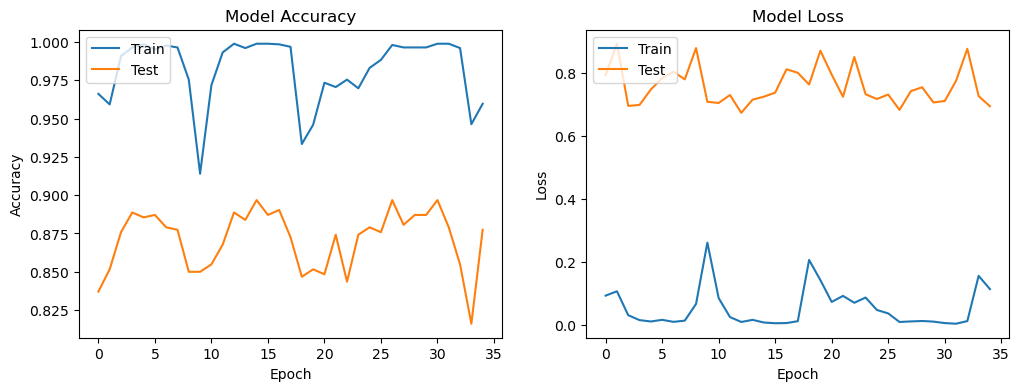

In [34]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [35]:
model5 = Sequential()

model5.add(Dense(1000, input_shape=(675,), activation='relu',kernel_regularizer=l2(0.01),  
                bias_regularizer=l1(0.01)))

model5.add(Dense(500, activation='relu'))
model5.add(Dense(250, activation='relu'))
model5.add(Dense(4, activation='softmax'))


model5.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
model5.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history5 = model5.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model5.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 1s 10ms/step - loss: 3.6912 - accuracy: 0.3800 - val_loss: 1.5735 - val_accuracy: 0.4484
Epoch 2/100
78/78 [==============================] - 1s 9ms/step - loss: 1.3718 - accuracy: 0.4867 - val_loss: 1.2851 - val_accuracy: 0.5081
Epoch 3/100
78/78 [==============================] - 1s 9ms/step - loss: 1.2304 - accuracy: 0.5077 - val_loss: 1.1817 - val_accuracy: 0.5355
Epoch 4/100
78/78 [==============================] - 1s 9ms/step - loss: 1.1417 - accuracy: 0.5497 - val_loss: 1.2718 - val_accuracy: 0.4581
Epoch 5/100
78/78 [==============================] - 1s 10ms/step - loss: 1.1441 - accuracy: 0.5489 - val_loss: 1.0997 - val_accuracy: 0.5952
Epoch 6/100
78/78 [==============================] - 1s 9ms/step - loss: 1.0687 - accuracy: 0.5820 - val_loss: 1.0301 - val_accuracy: 0.5919
Epoch 7/100
78/78 [==============================] - 1s 9ms/step - loss: 1.0589 - accuracy: 0.5953 - val_loss: 0.9907 - val_accuracy: 0.6323
Epoch 8/100

Epoch 59/100
78/78 [==============================] - 1s 9ms/step - loss: 0.6964 - accuracy: 0.7985 - val_loss: 0.8606 - val_accuracy: 0.7484
Epoch 60/100
78/78 [==============================] - 1s 9ms/step - loss: 0.7002 - accuracy: 0.8001 - val_loss: 0.8187 - val_accuracy: 0.7790
Epoch 61/100
78/78 [==============================] - 1s 9ms/step - loss: 0.6566 - accuracy: 0.8130 - val_loss: 0.7563 - val_accuracy: 0.7839
Epoch 62/100
78/78 [==============================] - 1s 9ms/step - loss: 0.6954 - accuracy: 0.8029 - val_loss: 0.7955 - val_accuracy: 0.7871
Epoch 63/100
78/78 [==============================] - 1s 9ms/step - loss: 0.6162 - accuracy: 0.8223 - val_loss: 0.7853 - val_accuracy: 0.7887
Epoch 64/100
78/78 [==============================] - 1s 9ms/step - loss: 0.6254 - accuracy: 0.8251 - val_loss: 0.7532 - val_accuracy: 0.7887
Epoch 65/100
78/78 [==============================] - 1s 9ms/step - loss: 0.6372 - accuracy: 0.8275 - val_loss: 0.7456 - val_accuracy: 0.7968
Epoch 

78/78 [==============================] - 1s 9ms/step - loss: 0.5188 - accuracy: 0.8760 - val_loss: 1.0536 - val_accuracy: 0.7290
Epoch 31/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5807 - accuracy: 0.8627 - val_loss: 0.8098 - val_accuracy: 0.8129
Epoch 32/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5218 - accuracy: 0.8800 - val_loss: 0.7109 - val_accuracy: 0.8339
Epoch 32: early stopping
20/20 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       180
           1       0.85      0.74      0.79       183
           2       0.90      0.89      0.89        88
           3       0.83      0.92      0.87       169

    accuracy                           0.83       620
   macro avg       0.84      0.84      0.84       620
weighted avg       0.84      0.83      0.83       620



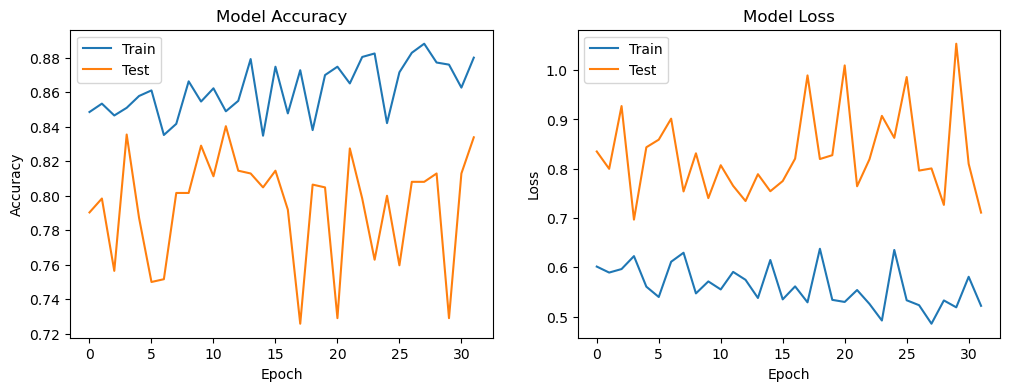

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [37]:
model6 = Sequential()
model6.add(Dense(600, input_shape=(675,), activation='relu'))
model6.add(Dropout(.2))
model6.add(Dense(300, activation='relu'))
model6.add(Dropout(.2))
model6.add(Dense(150, activation='relu'))
model6.add(Dense(75, activation='relu'))
model6.add(Dropout(.2))
model6.add(Dense(4, activation='softmax'))


model6.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_6.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
model6.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history6 = model6.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model6.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 1s 8ms/step - loss: 1.3575 - accuracy: 0.3211 - val_loss: 1.2790 - val_accuracy: 0.3758
Epoch 2/100
28/78 [=========>....................] - ETA: 0s - loss: 1.2825 - accuracy: 0.3929

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 1s 7ms/step - loss: 1.2339 - accuracy: 0.4285 - val_loss: 1.0931 - val_accuracy: 0.4806
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 1.1073 - accuracy: 0.5093 - val_loss: 1.1236 - val_accuracy: 0.5048
Epoch 4/100
78/78 [==============================] - 1s 7ms/step - loss: 1.0634 - accuracy: 0.5287 - val_loss: 0.9593 - val_accuracy: 0.5726
Epoch 5/100
78/78 [==============================] - 1s 7ms/step - loss: 0.9856 - accuracy: 0.5602 - val_loss: 0.9199 - val_accuracy: 0.6000
Epoch 6/100
78/78 [==============================] - 1s 7ms/step - loss: 0.9426 - accuracy: 0.5844 - val_loss: 0.9981 - val_accuracy: 0.5726
Epoch 7/100
78/78 [==============================] - 1s 7ms/step - loss: 0.9150 - accuracy: 0.5973 - val_loss: 0.8405 - val_accuracy: 0.6371
Epoch 8/100
78/78 [==============================] - 1s 7ms/step - loss: 0.9054 - accuracy: 0.6248 - val_loss: 0.8374 - val_accuracy: 0.6323
Epoch 9/100
78/78 [======

Epoch 60/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4467 - accuracy: 0.8324 - val_loss: 0.5475 - val_accuracy: 0.8113
Epoch 61/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4777 - accuracy: 0.8227 - val_loss: 0.5249 - val_accuracy: 0.8081
Epoch 62/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4887 - accuracy: 0.8130 - val_loss: 0.5073 - val_accuracy: 0.8226
Epoch 63/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4516 - accuracy: 0.8316 - val_loss: 0.6144 - val_accuracy: 0.7806
Epoch 64/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4616 - accuracy: 0.8267 - val_loss: 0.5337 - val_accuracy: 0.8161
Epoch 65/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4557 - accuracy: 0.8344 - val_loss: 0.4833 - val_accuracy: 0.8435
Epoch 66/100
78/78 [==============================] - 1s 7ms/step - loss: 0.4253 - accuracy: 0.8401 - val_loss: 0.5075 - val_accuracy: 0.8306
Epoch 

78/78 [==============================] - 0s 6ms/step - loss: 0.3581 - accuracy: 0.8683 - val_loss: 0.4926 - val_accuracy: 0.8081
Epoch 32: early stopping
20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       180
           1       0.79      0.68      0.73       183
           2       0.79      0.92      0.85        88
           3       0.83      0.89      0.86       169

    accuracy                           0.81       620
   macro avg       0.81      0.82      0.81       620
weighted avg       0.81      0.81      0.81       620



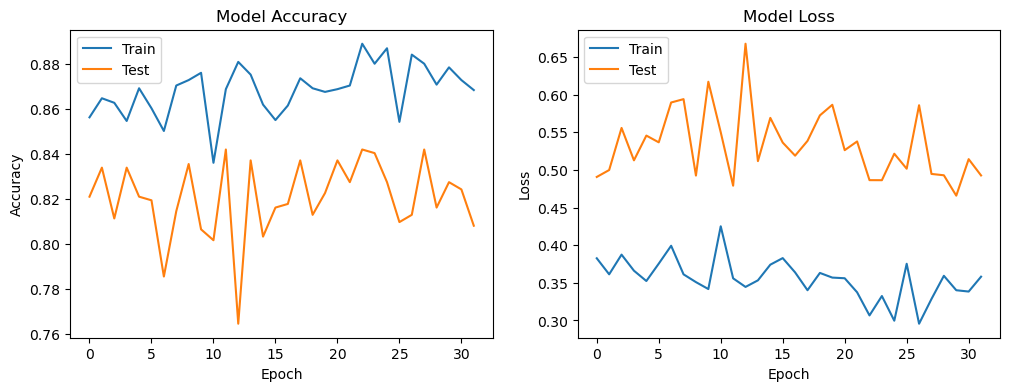

In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [39]:
model7 = Sequential()
model7.add(Dense(1000, input_shape=(675,), activation='relu'))
model7.add(Dropout(.2))
model7.add(Dense(500, activation='relu'))
model7.add(Dropout(.2))
model7.add(Dense(250, activation='relu'))
model7.add(Dropout(.2))
model7.add(Dense(4, activation='softmax'))


model7.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_7.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
model7.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
history7 = model7.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = model7.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 1s 11ms/step - loss: 1.3324 - accuracy: 0.3671 - val_loss: 1.3035 - val_accuracy: 0.3500
Epoch 2/100
19/78 [======>.......................] - ETA: 0s - loss: 1.2591 - accuracy: 0.3783

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 1s 10ms/step - loss: 1.1914 - accuracy: 0.4507 - val_loss: 1.1854 - val_accuracy: 0.4935
Epoch 3/100
78/78 [==============================] - 1s 11ms/step - loss: 1.1072 - accuracy: 0.4964 - val_loss: 1.0223 - val_accuracy: 0.5823
Epoch 4/100
78/78 [==============================] - 1s 10ms/step - loss: 1.0043 - accuracy: 0.5784 - val_loss: 0.9239 - val_accuracy: 0.6194
Epoch 5/100
78/78 [==============================] - 1s 10ms/step - loss: 0.9497 - accuracy: 0.5792 - val_loss: 0.9517 - val_accuracy: 0.5806
Epoch 6/100
78/78 [==============================] - 1s 10ms/step - loss: 0.9225 - accuracy: 0.5961 - val_loss: 0.9772 - val_accuracy: 0.5371
Epoch 7/100
78/78 [==============================] - 1s 10ms/step - loss: 0.8848 - accuracy: 0.6204 - val_loss: 0.8021 - val_accuracy: 0.6903
Epoch 8/100
78/78 [==============================] - 1s 10ms/step - loss: 0.8481 - accuracy: 0.6397 - val_loss: 0.7897 - val_accuracy: 0.6952
Epoch 9/100
78/78 

78/78 [==============================] - 1s 11ms/step - loss: 0.4444 - accuracy: 0.8251 - val_loss: 0.4804 - val_accuracy: 0.8210
Epoch 60/100
78/78 [==============================] - 1s 10ms/step - loss: 0.4861 - accuracy: 0.8154 - val_loss: 0.5646 - val_accuracy: 0.7952
Epoch 61/100
78/78 [==============================] - 1s 10ms/step - loss: 0.4410 - accuracy: 0.8348 - val_loss: 0.5035 - val_accuracy: 0.8113
Epoch 62/100
78/78 [==============================] - 1s 11ms/step - loss: 0.4177 - accuracy: 0.8429 - val_loss: 0.4852 - val_accuracy: 0.8258
Epoch 63/100
78/78 [==============================] - 1s 10ms/step - loss: 0.4162 - accuracy: 0.8340 - val_loss: 0.5163 - val_accuracy: 0.8113
Epoch 64/100
78/78 [==============================] - 1s 10ms/step - loss: 0.4298 - accuracy: 0.8320 - val_loss: 0.4836 - val_accuracy: 0.8145
Epoch 65/100
78/78 [==============================] - 1s 10ms/step - loss: 0.4172 - accuracy: 0.8477 - val_loss: 0.5878 - val_accuracy: 0.7919
Epoch 66/100

78/78 [==============================] - 1s 10ms/step - loss: 0.3024 - accuracy: 0.8861 - val_loss: 0.6153 - val_accuracy: 0.8306
Epoch 17/100
78/78 [==============================] - 1s 10ms/step - loss: 0.2859 - accuracy: 0.8926 - val_loss: 0.5510 - val_accuracy: 0.8371
Epoch 18/100
78/78 [==============================] - 1s 10ms/step - loss: 0.2511 - accuracy: 0.9043 - val_loss: 0.6097 - val_accuracy: 0.8258
Epoch 19/100
78/78 [==============================] - 1s 10ms/step - loss: 0.2770 - accuracy: 0.9011 - val_loss: 0.5732 - val_accuracy: 0.8484
Epoch 20/100
78/78 [==============================] - 1s 10ms/step - loss: 0.2695 - accuracy: 0.9047 - val_loss: 0.5577 - val_accuracy: 0.8435
Epoch 21/100
78/78 [==============================] - 1s 10ms/step - loss: 0.2784 - accuracy: 0.8942 - val_loss: 0.5358 - val_accuracy: 0.8548
Epoch 22/100
78/78 [==============================] - 1s 10ms/step - loss: 0.3153 - accuracy: 0.8780 - val_loss: 0.5228 - val_accuracy: 0.8468
Epoch 23/100

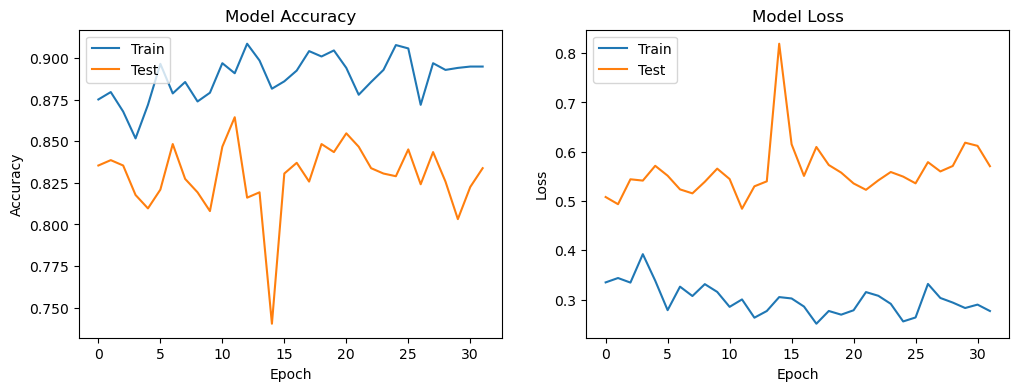

In [40]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [41]:
def create_model(X_train, y_train, X_test, y_test, optimizer, loss, activation):

    model = Sequential()
    model.add(Dense(600, input_shape=(675,), activation=activation))
    model.add(Dropout(.2))
    model.add(Dense(300, activation=activation))
    model.add(Dropout(.2))
    model.add(Dense(150, activation=activation))
    model.add(Dense(75, activation=activation))
    model.add(Dropout(.2))
    model.add(Dense(4, activation='softmax'))


    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])



    y_preds = model.predict(X_test)
    class_predictions = np.argmax(y_preds, axis=1)

    report = accuracy_score(class_predictions, y_test)
    return report



In [49]:
optimizers_list = ['SGD', 'Adam', 'RMSprop']
activation_functions_list = ['relu', 'sigmoid']


best_acc = 0
best_params = None

for optimizer in optimizers_list:
    for activation in activation_functions_list:
        
        accuracy = create_model(X_train, y_train, X_test, y_test,optimizer=optimizer, activation=activation,loss='sparse_categorical_crossentropy')
        print(f'Optimizer = {optimizer}, Activation = {activation}')
        print(f"Accuracy: {accuracy:.2%}")

        if accuracy > best_acc:
            best_acc = accuracy
            best_params = (optimizer, activation)

print(f"Best Parameters: Optimizer = {best_params[0]}, Activation = {best_params[1]} with Accuracy = {best_acc:.2%}")



Epoch 1/100
78/78 [==============================] - 1s 8ms/step - loss: 1.3624 - accuracy: 0.3102 - val_loss: 1.3428 - val_accuracy: 0.3016
Epoch 2/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3465 - accuracy: 0.3211 - val_loss: 1.3208 - val_accuracy: 0.4145
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3324 - accuracy: 0.3724 - val_loss: 1.2987 - val_accuracy: 0.4355
Epoch 4/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3176 - accuracy: 0.3792 - val_loss: 1.2753 - val_accuracy: 0.4323
Epoch 5/100
78/78 [==============================] - 0s 5ms/step - loss: 1.2968 - accuracy: 0.4059 - val_loss: 1.2569 - val_accuracy: 0.4387
Epoch 6/100
78/78 [==============================] - 0s 5ms/step - loss: 1.2835 - accuracy: 0.4087 - val_loss: 1.2354 - val_accuracy: 0.4613
Epoch 7/100
78/78 [==============================] - 0s 5ms/step - loss: 1.2627 - accuracy: 0.4378 - val_loss: 1.2224 - val_accuracy: 0.4661
Epoch 8/100
7

Epoch 59/100
78/78 [==============================] - 0s 5ms/step - loss: 0.6219 - accuracy: 0.7573 - val_loss: 0.8068 - val_accuracy: 0.6565
Epoch 60/100
78/78 [==============================] - 0s 5ms/step - loss: 0.5941 - accuracy: 0.7718 - val_loss: 0.7043 - val_accuracy: 0.7097
Epoch 61/100
78/78 [==============================] - 0s 5ms/step - loss: 0.5914 - accuracy: 0.7815 - val_loss: 0.6328 - val_accuracy: 0.7645
Epoch 62/100
78/78 [==============================] - 0s 5ms/step - loss: 0.5989 - accuracy: 0.7658 - val_loss: 0.6359 - val_accuracy: 0.7919
Epoch 63/100
78/78 [==============================] - 0s 5ms/step - loss: 0.5747 - accuracy: 0.7916 - val_loss: 0.6117 - val_accuracy: 0.7806
Epoch 64/100
78/78 [==============================] - 0s 5ms/step - loss: 0.5761 - accuracy: 0.7803 - val_loss: 0.7227 - val_accuracy: 0.7548
Epoch 65/100
78/78 [==============================] - 0s 5ms/step - loss: 0.5460 - accuracy: 0.7973 - val_loss: 0.5672 - val_accuracy: 0.7919
Epoch 

78/78 [==============================] - 0s 5ms/step - loss: 1.3763 - accuracy: 0.2791 - val_loss: 1.3515 - val_accuracy: 0.2903
Epoch 17/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3730 - accuracy: 0.2855 - val_loss: 1.3526 - val_accuracy: 0.2952
Epoch 18/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3763 - accuracy: 0.2851 - val_loss: 1.3508 - val_accuracy: 0.2952
Epoch 19/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3723 - accuracy: 0.3037 - val_loss: 1.3516 - val_accuracy: 0.2903
Epoch 20/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3697 - accuracy: 0.2868 - val_loss: 1.3515 - val_accuracy: 0.2903
Epoch 21/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3713 - accuracy: 0.2823 - val_loss: 1.3515 - val_accuracy: 0.2742
Epoch 22/100
78/78 [==============================] - 0s 5ms/step - loss: 1.3693 - accuracy: 0.2827 - val_loss: 1.3521 - val_accuracy: 0.2952
Epoch 22: early sto

Epoch 51/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5169 - accuracy: 0.8025 - val_loss: 0.5040 - val_accuracy: 0.8129
Epoch 52/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5054 - accuracy: 0.7989 - val_loss: 0.5117 - val_accuracy: 0.8113
Epoch 53/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5112 - accuracy: 0.8005 - val_loss: 0.5363 - val_accuracy: 0.8129
Epoch 54/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4988 - accuracy: 0.8013 - val_loss: 0.5701 - val_accuracy: 0.7871
Epoch 55/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4942 - accuracy: 0.8082 - val_loss: 0.5171 - val_accuracy: 0.8226
Epoch 56/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5015 - accuracy: 0.8033 - val_loss: 0.5412 - val_accuracy: 0.8194
Epoch 57/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4820 - accuracy: 0.8130 - val_loss: 0.5476 - val_accuracy: 0.8177
Epoch 

Epoch 25/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8028 - accuracy: 0.6733 - val_loss: 0.7645 - val_accuracy: 0.6919
Epoch 26/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7935 - accuracy: 0.6850 - val_loss: 0.7661 - val_accuracy: 0.6919
Epoch 27/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7856 - accuracy: 0.6910 - val_loss: 0.7398 - val_accuracy: 0.6871
Epoch 28/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7907 - accuracy: 0.6805 - val_loss: 0.8643 - val_accuracy: 0.6532
Epoch 29/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7566 - accuracy: 0.7032 - val_loss: 0.7494 - val_accuracy: 0.7048
Epoch 30/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7633 - accuracy: 0.7040 - val_loss: 0.7031 - val_accuracy: 0.7274
Epoch 31/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7368 - accuracy: 0.7128 - val_loss: 0.6978 - val_accuracy: 0.7226
Epoch 

Epoch 83/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4477 - accuracy: 0.8308 - val_loss: 0.5450 - val_accuracy: 0.8065
Epoch 84/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4382 - accuracy: 0.8312 - val_loss: 0.5605 - val_accuracy: 0.8000
Epoch 85/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4519 - accuracy: 0.8284 - val_loss: 0.5321 - val_accuracy: 0.8145
Epoch 86/100
78/78 [==============================] - 1s 7ms/step - loss: 0.4438 - accuracy: 0.8308 - val_loss: 0.5715 - val_accuracy: 0.7952
Epoch 87/100
78/78 [==============================] - 1s 6ms/step - loss: 0.4147 - accuracy: 0.8425 - val_loss: 0.5267 - val_accuracy: 0.8129
Epoch 88/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4514 - accuracy: 0.8368 - val_loss: 0.5056 - val_accuracy: 0.8210
Epoch 89/100
78/78 [==============================] - 1s 7ms/step - loss: 0.4146 - accuracy: 0.8457 - val_loss: 0.5894 - val_accuracy: 0.7887
Epoch 

Epoch 40/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5334 - accuracy: 0.7932 - val_loss: 0.7537 - val_accuracy: 0.7210
Epoch 41/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5135 - accuracy: 0.7956 - val_loss: 0.5677 - val_accuracy: 0.8065
Epoch 42/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5282 - accuracy: 0.7916 - val_loss: 0.5993 - val_accuracy: 0.7661
Epoch 43/100
78/78 [==============================] - 0s 5ms/step - loss: 0.4961 - accuracy: 0.8090 - val_loss: 0.8226 - val_accuracy: 0.7145
Epoch 44/100
78/78 [==============================] - 0s 5ms/step - loss: 0.4839 - accuracy: 0.8174 - val_loss: 0.8023 - val_accuracy: 0.7419
Epoch 45/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5080 - accuracy: 0.8126 - val_loss: 0.6049 - val_accuracy: 0.8016
Epoch 46/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4831 - accuracy: 0.8102 - val_loss: 0.5091 - val_accuracy: 0.8194
Epoch 

Epoch 8/100
78/78 [==============================] - 0s 6ms/step - loss: 1.3527 - accuracy: 0.3074 - val_loss: 1.3449 - val_accuracy: 0.3129
Epoch 9/100
78/78 [==============================] - 0s 6ms/step - loss: 1.3461 - accuracy: 0.3098 - val_loss: 1.3421 - val_accuracy: 0.2952
Epoch 10/100
78/78 [==============================] - 0s 6ms/step - loss: 1.3328 - accuracy: 0.3275 - val_loss: 1.2978 - val_accuracy: 0.3823
Epoch 11/100
78/78 [==============================] - 0s 6ms/step - loss: 1.2966 - accuracy: 0.3675 - val_loss: 1.3083 - val_accuracy: 0.3452
Epoch 12/100
78/78 [==============================] - 0s 6ms/step - loss: 1.2593 - accuracy: 0.3461 - val_loss: 1.2959 - val_accuracy: 0.3161
Epoch 13/100
78/78 [==============================] - 0s 6ms/step - loss: 1.2542 - accuracy: 0.3716 - val_loss: 1.2241 - val_accuracy: 0.3516
Epoch 14/100
78/78 [==============================] - 0s 6ms/step - loss: 1.2335 - accuracy: 0.3837 - val_loss: 1.2013 - val_accuracy: 0.3597
Epoch 15

Epoch 66/100
78/78 [==============================] - 0s 5ms/step - loss: 0.8167 - accuracy: 0.6781 - val_loss: 0.7728 - val_accuracy: 0.7016
Epoch 67/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8116 - accuracy: 0.6692 - val_loss: 0.8275 - val_accuracy: 0.6855
Epoch 68/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8008 - accuracy: 0.6834 - val_loss: 0.9175 - val_accuracy: 0.6306
Epoch 69/100
78/78 [==============================] - 0s 5ms/step - loss: 0.8095 - accuracy: 0.6797 - val_loss: 0.8425 - val_accuracy: 0.6677
Epoch 70/100
78/78 [==============================] - 0s 5ms/step - loss: 0.8062 - accuracy: 0.6834 - val_loss: 0.7883 - val_accuracy: 0.6919
Epoch 71/100
78/78 [==============================] - 0s 5ms/step - loss: 0.7885 - accuracy: 0.6821 - val_loss: 1.1923 - val_accuracy: 0.5629
Epoch 72/100
78/78 [==============================] - 0s 5ms/step - loss: 0.7970 - accuracy: 0.6870 - val_loss: 0.8475 - val_accuracy: 0.6613
Epoch 

In [50]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from keras.utils import to_categorical
import numpy as np

# Combine X_train and X_test for cross-validation
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Convert labels to categorical
y_cat = to_categorical(y, num_classes=4)
dropouts = [.2, .25, .3]

best_acc = 0
best_drop = None

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
for drop in dropouts:
    fold_no = 1
    for train, test in kfold.split(X, y):
        # Create the model
        model = Sequential()
        model.add(Dense(600, input_shape=(675,), activation='relu'))
        model.add(Dropout(drop))
        model.add(Dense(300, activation='relu'))
        model.add(Dropout(drop))
        model.add(Dense(150, activation='relu'))
        model.add(Dense(75, activation='relu'))
        model.add(Dropout(drop))
        model.add(Dense(4, activation='softmax'))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Generate a print
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
        model.fit(X[train], y_cat[train], epochs=100, validation_data=(X[test], y_cat[test]), callbacks=[early_stop])

        # Generate generalization metrics
        y_preds = model.predict(X[test])
        class_predictions = np.argmax(y_preds, axis=1)
        y_test_fold = np.argmax(y_cat[test], axis=1)
        accuracy = accuracy_score(y_test_fold, class_predictions)

        print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {accuracy};')
        print(classification_report(y_test_fold, class_predictions))

        if accuracy > best_acc:
            best_acc = accuracy
            best_drop = drop

        # Increase fold number
        fold_no += 1

print(f"Best accuracy = {best_acc}, Best dropout = {best_drop}")



Training for fold 1 ...
Epoch 1/100
78/78 [==============================] - 2s 9ms/step - loss: 1.3361 - accuracy: 0.3538 - val_loss: 1.2695 - val_accuracy: 0.4242
Epoch 2/100
78/78 [==============================] - 0s 6ms/step - loss: 1.2220 - accuracy: 0.4204 - val_loss: 1.1271 - val_accuracy: 0.5177
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 1.1029 - accuracy: 0.5113 - val_loss: 1.0172 - val_accuracy: 0.5677
Epoch 4/100
78/78 [==============================] - 1s 6ms/step - loss: 1.0215 - accuracy: 0.5440 - val_loss: 0.9812 - val_accuracy: 0.6032
Epoch 5/100
78/78 [==============================] - 1s 6ms/step - loss: 0.9513 - accuracy: 0.5872 - val_loss: 0.9183 - val_accuracy: 0.6048
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9023 - accuracy: 0.6232 - val_loss: 0.8768 - val_accuracy: 0.6597
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9062 - accuracy: 0.6095 - val_loss: 0.8961 - val_accura

78/78 [==============================] - 0s 6ms/step - loss: 0.4002 - accuracy: 0.8461 - val_loss: 0.6060 - val_accuracy: 0.8065
Epoch 59/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4151 - accuracy: 0.8481 - val_loss: 0.6013 - val_accuracy: 0.8065
Epoch 60/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4493 - accuracy: 0.8263 - val_loss: 0.5819 - val_accuracy: 0.8097
Epoch 61/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4045 - accuracy: 0.8461 - val_loss: 0.6101 - val_accuracy: 0.8000
Epoch 62/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4076 - accuracy: 0.8457 - val_loss: 0.5995 - val_accuracy: 0.8129
Epoch 63/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3959 - accuracy: 0.8485 - val_loss: 0.6171 - val_accuracy: 0.7968
Epoch 64/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4156 - accuracy: 0.8437 - val_loss: 0.6306 - val_accuracy: 0.7984
Epoch 65/100
78/78 

Epoch 13/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8064 - accuracy: 0.6710 - val_loss: 0.7600 - val_accuracy: 0.6882
Epoch 14/100
78/78 [==============================] - 1s 7ms/step - loss: 0.7794 - accuracy: 0.6799 - val_loss: 0.7441 - val_accuracy: 0.7060
Epoch 15/100
78/78 [==============================] - 1s 6ms/step - loss: 0.7584 - accuracy: 0.6924 - val_loss: 0.7475 - val_accuracy: 0.7124
Epoch 16/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7441 - accuracy: 0.7057 - val_loss: 0.7264 - val_accuracy: 0.7254
Epoch 17/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7425 - accuracy: 0.6996 - val_loss: 0.7373 - val_accuracy: 0.7011
Epoch 18/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7325 - accuracy: 0.7093 - val_loss: 0.7873 - val_accuracy: 0.6914
Epoch 19/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7081 - accuracy: 0.7186 - val_loss: 0.8106 - val_accuracy: 0.6931
Epoch 

Epoch 71/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4217 - accuracy: 0.8510 - val_loss: 0.5995 - val_accuracy: 0.7981
Epoch 72/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3964 - accuracy: 0.8494 - val_loss: 0.5426 - val_accuracy: 0.8255
Epoch 73/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3509 - accuracy: 0.8684 - val_loss: 0.6196 - val_accuracy: 0.7722
Epoch 74/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3990 - accuracy: 0.8522 - val_loss: 0.6190 - val_accuracy: 0.8045
Epoch 75/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3848 - accuracy: 0.8575 - val_loss: 0.5617 - val_accuracy: 0.8191
Epoch 76/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4107 - accuracy: 0.8478 - val_loss: 0.5921 - val_accuracy: 0.7981
Epoch 77/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3574 - accuracy: 0.8708 - val_loss: 0.6304 - val_accuracy: 0.8142
Epoch 

Epoch 25/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6570 - accuracy: 0.7412 - val_loss: 0.7545 - val_accuracy: 0.7076
Epoch 26/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6558 - accuracy: 0.7412 - val_loss: 0.6619 - val_accuracy: 0.7480
Epoch 27/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6339 - accuracy: 0.7477 - val_loss: 0.7620 - val_accuracy: 0.7157
Epoch 28/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6605 - accuracy: 0.7356 - val_loss: 0.6714 - val_accuracy: 0.7593
Epoch 29/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6365 - accuracy: 0.7517 - val_loss: 0.6571 - val_accuracy: 0.7609
Epoch 30/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6155 - accuracy: 0.7529 - val_loss: 0.6227 - val_accuracy: 0.7754
Epoch 31/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6228 - accuracy: 0.7566 - val_loss: 0.6992 - val_accuracy: 0.7593
Epoch 

Epoch 1/100
78/78 [==============================] - 1s 8ms/step - loss: 1.3501 - accuracy: 0.3371 - val_loss: 1.2164 - val_accuracy: 0.4475
Epoch 2/100
78/78 [==============================] - 0s 6ms/step - loss: 1.2168 - accuracy: 0.4509 - val_loss: 1.0598 - val_accuracy: 0.5267
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 1.1475 - accuracy: 0.4925 - val_loss: 1.0489 - val_accuracy: 0.5913
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0294 - accuracy: 0.5495 - val_loss: 0.9459 - val_accuracy: 0.6042
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9787 - accuracy: 0.5749 - val_loss: 0.8547 - val_accuracy: 0.6543
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9571 - accuracy: 0.5866 - val_loss: 0.8899 - val_accuracy: 0.6155
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9212 - accuracy: 0.6145 - val_loss: 0.8735 - val_accuracy: 0.6446
Epoch 8/100
7

Epoch 59/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4310 - accuracy: 0.8341 - val_loss: 0.5694 - val_accuracy: 0.7884
Epoch 60/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4535 - accuracy: 0.8317 - val_loss: 0.5742 - val_accuracy: 0.8013
Epoch 61/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4407 - accuracy: 0.8312 - val_loss: 0.5632 - val_accuracy: 0.8126
Epoch 62/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4098 - accuracy: 0.8474 - val_loss: 0.5809 - val_accuracy: 0.7900
Epoch 63/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4200 - accuracy: 0.8466 - val_loss: 0.5110 - val_accuracy: 0.8384
Epoch 64/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4026 - accuracy: 0.8442 - val_loss: 0.5299 - val_accuracy: 0.8158
Epoch 65/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4321 - accuracy: 0.8365 - val_loss: 0.5526 - val_accuracy: 0.8078
Epoch 

78/78 [==============================] - 1s 7ms/step - loss: 0.7806 - accuracy: 0.6819 - val_loss: 0.8636 - val_accuracy: 0.6462
Epoch 13/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8144 - accuracy: 0.6447 - val_loss: 0.8766 - val_accuracy: 0.6252
Epoch 14/100
78/78 [==============================] - 1s 7ms/step - loss: 0.7880 - accuracy: 0.6734 - val_loss: 0.8440 - val_accuracy: 0.6478
Epoch 15/100
78/78 [==============================] - 1s 7ms/step - loss: 0.7441 - accuracy: 0.7021 - val_loss: 0.8717 - val_accuracy: 0.6397
Epoch 16/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7517 - accuracy: 0.6952 - val_loss: 0.8602 - val_accuracy: 0.6494
Epoch 17/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7369 - accuracy: 0.6932 - val_loss: 0.8474 - val_accuracy: 0.6349
Epoch 18/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7256 - accuracy: 0.7017 - val_loss: 0.8116 - val_accuracy: 0.6834
Epoch 19/100
78/78 

Epoch 70/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3992 - accuracy: 0.8470 - val_loss: 0.6980 - val_accuracy: 0.7706
Epoch 71/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4199 - accuracy: 0.8389 - val_loss: 0.6553 - val_accuracy: 0.7932
Epoch 72/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3945 - accuracy: 0.8482 - val_loss: 0.6771 - val_accuracy: 0.7932
Epoch 73/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4316 - accuracy: 0.8454 - val_loss: 0.6731 - val_accuracy: 0.7738
Epoch 74/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3944 - accuracy: 0.8514 - val_loss: 0.7229 - val_accuracy: 0.7658
Epoch 75/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3925 - accuracy: 0.8575 - val_loss: 0.6637 - val_accuracy: 0.7706
Epoch 76/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3894 - accuracy: 0.8547 - val_loss: 0.6869 - val_accuracy: 0.7851
Epoch 

Epoch 24/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6965 - accuracy: 0.7173 - val_loss: 0.7223 - val_accuracy: 0.7371
Epoch 25/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7024 - accuracy: 0.7177 - val_loss: 0.7524 - val_accuracy: 0.7065
Epoch 26/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.7254 - val_loss: 0.7471 - val_accuracy: 0.7145
Epoch 27/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7173 - accuracy: 0.7084 - val_loss: 0.7804 - val_accuracy: 0.6871
Epoch 28/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6954 - accuracy: 0.7145 - val_loss: 0.7184 - val_accuracy: 0.7339
Epoch 29/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7016 - accuracy: 0.7145 - val_loss: 0.6633 - val_accuracy: 0.7387
Epoch 30/100
78/78 [==============================] - 1s 7ms/step - loss: 0.6860 - accuracy: 0.7104 - val_loss: 0.6647 - val_accuracy: 0.7565
Epoch 

Epoch 82/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4311 - accuracy: 0.8433 - val_loss: 0.5595 - val_accuracy: 0.8242
Epoch 83/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4453 - accuracy: 0.8316 - val_loss: 0.5829 - val_accuracy: 0.8032
Epoch 84/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4403 - accuracy: 0.8340 - val_loss: 0.5828 - val_accuracy: 0.8032
Epoch 85/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4480 - accuracy: 0.8360 - val_loss: 0.5977 - val_accuracy: 0.8113
Epoch 86/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4346 - accuracy: 0.8421 - val_loss: 0.5749 - val_accuracy: 0.8274
Epoch 87/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4008 - accuracy: 0.8526 - val_loss: 0.6440 - val_accuracy: 0.7823
Epoch 88/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4714 - accuracy: 0.8231 - val_loss: 0.6345 - val_accuracy: 0.7742
Epoch 

Epoch 36/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6409 - accuracy: 0.7469 - val_loss: 0.6849 - val_accuracy: 0.7237
Epoch 37/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6300 - accuracy: 0.7380 - val_loss: 0.6378 - val_accuracy: 0.7496
Epoch 38/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6092 - accuracy: 0.7675 - val_loss: 0.6638 - val_accuracy: 0.7577
Epoch 39/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6090 - accuracy: 0.7667 - val_loss: 0.6240 - val_accuracy: 0.7690
Epoch 40/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5933 - accuracy: 0.7691 - val_loss: 0.6224 - val_accuracy: 0.7431
Epoch 41/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5926 - accuracy: 0.7667 - val_loss: 0.6722 - val_accuracy: 0.7447
Epoch 42/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6097 - accuracy: 0.7642 - val_loss: 0.6533 - val_accuracy: 0.7609
Epoch 

Epoch 94/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4122 - accuracy: 0.8454 - val_loss: 0.5892 - val_accuracy: 0.8061
Epoch 95/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3982 - accuracy: 0.8522 - val_loss: 0.6000 - val_accuracy: 0.7997
Epoch 96/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3932 - accuracy: 0.8583 - val_loss: 0.5965 - val_accuracy: 0.7884
Epoch 97/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3744 - accuracy: 0.8668 - val_loss: 0.5383 - val_accuracy: 0.8191
Epoch 98/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4126 - accuracy: 0.8470 - val_loss: 0.5646 - val_accuracy: 0.8158
Epoch 99/100
78/78 [==============================] - 1s 6ms/step - loss: 0.3615 - accuracy: 0.8607 - val_loss: 0.6632 - val_accuracy: 0.7738
Epoch 100/100
78/78 [==============================] - 0s 6ms/step - loss: 0.3862 - accuracy: 0.8563 - val_loss: 0.5850 - val_accuracy: 0.7900
Epoch

78/78 [==============================] - 0s 6ms/step - loss: 0.5644 - accuracy: 0.7872 - val_loss: 0.7010 - val_accuracy: 0.7351
Epoch 48/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5478 - accuracy: 0.7921 - val_loss: 0.6911 - val_accuracy: 0.7237
Epoch 49/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5942 - accuracy: 0.7671 - val_loss: 0.6509 - val_accuracy: 0.7593
Epoch 50/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5723 - accuracy: 0.7727 - val_loss: 0.6565 - val_accuracy: 0.7496
Epoch 51/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5272 - accuracy: 0.7990 - val_loss: 0.6380 - val_accuracy: 0.7609
Epoch 52/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5249 - accuracy: 0.7933 - val_loss: 0.6388 - val_accuracy: 0.7544
Epoch 53/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5393 - accuracy: 0.7961 - val_loss: 0.6289 - val_accuracy: 0.7706
Epoch 54/100
78/78 

Training for fold 4 ...
Epoch 1/100
78/78 [==============================] - 2s 8ms/step - loss: 1.3584 - accuracy: 0.3290 - val_loss: 1.2663 - val_accuracy: 0.3877
Epoch 2/100
78/78 [==============================] - 1s 7ms/step - loss: 1.2803 - accuracy: 0.3892 - val_loss: 1.1511 - val_accuracy: 0.5008
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 1.2004 - accuracy: 0.4534 - val_loss: 1.1161 - val_accuracy: 0.4960
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 1.1109 - accuracy: 0.5018 - val_loss: 0.9692 - val_accuracy: 0.5541
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0475 - accuracy: 0.5337 - val_loss: 0.9400 - val_accuracy: 0.5751
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9984 - accuracy: 0.5563 - val_loss: 0.9114 - val_accuracy: 0.6220
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9661 - accuracy: 0.5737 - val_loss: 0.9153 - val_accura

78/78 [==============================] - 1s 7ms/step - loss: 0.5120 - accuracy: 0.8070 - val_loss: 0.5864 - val_accuracy: 0.7884
Epoch 59/100
78/78 [==============================] - 1s 7ms/step - loss: 0.5625 - accuracy: 0.7864 - val_loss: 0.7002 - val_accuracy: 0.7496
Epoch 60/100
78/78 [==============================] - 1s 7ms/step - loss: 0.5413 - accuracy: 0.7876 - val_loss: 0.6245 - val_accuracy: 0.7593
Epoch 61/100
78/78 [==============================] - 1s 7ms/step - loss: 0.5056 - accuracy: 0.8074 - val_loss: 0.6100 - val_accuracy: 0.7738
Epoch 62/100
78/78 [==============================] - 1s 7ms/step - loss: 0.4971 - accuracy: 0.8078 - val_loss: 0.5982 - val_accuracy: 0.7900
Epoch 63/100
78/78 [==============================] - 1s 7ms/step - loss: 0.5207 - accuracy: 0.8026 - val_loss: 0.5960 - val_accuracy: 0.7787
Epoch 64/100
78/78 [==============================] - 1s 7ms/step - loss: 0.5087 - accuracy: 0.7957 - val_loss: 0.5866 - val_accuracy: 0.7851
Epoch 65/100
78/78 

Epoch 12/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8462 - accuracy: 0.6431 - val_loss: 0.8613 - val_accuracy: 0.6478
Epoch 13/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8190 - accuracy: 0.6540 - val_loss: 0.8421 - val_accuracy: 0.6575
Epoch 14/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8142 - accuracy: 0.6633 - val_loss: 0.7987 - val_accuracy: 0.6834
Epoch 15/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8029 - accuracy: 0.6718 - val_loss: 0.8519 - val_accuracy: 0.6446
Epoch 16/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7837 - accuracy: 0.6831 - val_loss: 0.8967 - val_accuracy: 0.6171
Epoch 17/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7588 - accuracy: 0.6883 - val_loss: 0.8806 - val_accuracy: 0.6511
Epoch 18/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7677 - accuracy: 0.6807 - val_loss: 0.7901 - val_accuracy: 0.6704
Epoch 

Epoch 70/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4834 - accuracy: 0.8086 - val_loss: 0.6808 - val_accuracy: 0.7658
Epoch 71/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4469 - accuracy: 0.8325 - val_loss: 0.7067 - val_accuracy: 0.7625
Epoch 72/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4485 - accuracy: 0.8345 - val_loss: 0.6715 - val_accuracy: 0.7754
Epoch 73/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4920 - accuracy: 0.8107 - val_loss: 0.6558 - val_accuracy: 0.7706
Epoch 74/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4606 - accuracy: 0.8333 - val_loss: 0.7270 - val_accuracy: 0.7528
Epoch 75/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4624 - accuracy: 0.8268 - val_loss: 0.6515 - val_accuracy: 0.7690
Epoch 76/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4517 - accuracy: 0.8365 - val_loss: 0.7464 - val_accuracy: 0.7480
Epoch 

Epoch 24/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7484 - accuracy: 0.6914 - val_loss: 0.8121 - val_accuracy: 0.6629
Epoch 25/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7356 - accuracy: 0.6999 - val_loss: 0.8350 - val_accuracy: 0.6371
Epoch 26/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7708 - accuracy: 0.6858 - val_loss: 0.7841 - val_accuracy: 0.6710
Epoch 27/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7603 - accuracy: 0.6826 - val_loss: 0.7588 - val_accuracy: 0.6984
Epoch 28/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7481 - accuracy: 0.6935 - val_loss: 0.7654 - val_accuracy: 0.6952
Epoch 29/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7657 - accuracy: 0.6910 - val_loss: 0.7499 - val_accuracy: 0.6855
Epoch 30/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7159 - accuracy: 0.7149 - val_loss: 0.7608 - val_accuracy: 0.7113
Epoch 

Epoch 82/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5314 - accuracy: 0.8017 - val_loss: 0.6459 - val_accuracy: 0.7710
Epoch 83/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5239 - accuracy: 0.8001 - val_loss: 0.6816 - val_accuracy: 0.7452
Epoch 84/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5581 - accuracy: 0.7932 - val_loss: 0.6470 - val_accuracy: 0.7581
Epoch 85/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5014 - accuracy: 0.8078 - val_loss: 0.6799 - val_accuracy: 0.7677
Epoch 86/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4965 - accuracy: 0.8174 - val_loss: 0.6705 - val_accuracy: 0.7500
Epoch 87/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5258 - accuracy: 0.7944 - val_loss: 0.6643 - val_accuracy: 0.7597
Epoch 88/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5079 - accuracy: 0.8065 - val_loss: 0.6951 - val_accuracy: 0.7532
Epoch 

Epoch 36/100
78/78 [==============================] - 1s 11ms/step - loss: 0.6848 - accuracy: 0.7400 - val_loss: 0.7909 - val_accuracy: 0.6979
Epoch 37/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6735 - accuracy: 0.7271 - val_loss: 0.7361 - val_accuracy: 0.7496
Epoch 38/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6406 - accuracy: 0.7549 - val_loss: 0.7655 - val_accuracy: 0.7157
Epoch 39/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6711 - accuracy: 0.7352 - val_loss: 0.7513 - val_accuracy: 0.7496
Epoch 40/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6341 - accuracy: 0.7582 - val_loss: 0.7381 - val_accuracy: 0.7447
Epoch 41/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6481 - accuracy: 0.7449 - val_loss: 0.7259 - val_accuracy: 0.7738
Epoch 42/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6562 - accuracy: 0.7432 - val_loss: 0.8441 - val_accuracy: 0.7108

78/78 [==============================] - 1s 10ms/step - loss: 1.1610 - accuracy: 0.4635 - val_loss: 1.1086 - val_accuracy: 0.4943
Epoch 4/100
78/78 [==============================] - 1s 10ms/step - loss: 1.1019 - accuracy: 0.5022 - val_loss: 1.0841 - val_accuracy: 0.5250
Epoch 5/100
78/78 [==============================] - 1s 10ms/step - loss: 1.0479 - accuracy: 0.5394 - val_loss: 0.9745 - val_accuracy: 0.5994
Epoch 6/100
78/78 [==============================] - 1s 10ms/step - loss: 0.9824 - accuracy: 0.5696 - val_loss: 0.9728 - val_accuracy: 0.5557
Epoch 7/100
78/78 [==============================] - 1s 10ms/step - loss: 0.9790 - accuracy: 0.5668 - val_loss: 0.9579 - val_accuracy: 0.5670
Epoch 8/100
78/78 [==============================] - 1s 10ms/step - loss: 0.9553 - accuracy: 0.5850 - val_loss: 0.9177 - val_accuracy: 0.6026
Epoch 9/100
78/78 [==============================] - 1s 10ms/step - loss: 0.9204 - accuracy: 0.6128 - val_loss: 0.8811 - val_accuracy: 0.6349
Epoch 10/100
78/78

78/78 [==============================] - 1s 10ms/step - loss: 0.5804 - accuracy: 0.7747 - val_loss: 0.6806 - val_accuracy: 0.7286
Epoch 61/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5648 - accuracy: 0.7852 - val_loss: 0.6660 - val_accuracy: 0.7722
Epoch 62/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5903 - accuracy: 0.7739 - val_loss: 0.6652 - val_accuracy: 0.7706
Epoch 63/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5907 - accuracy: 0.7767 - val_loss: 0.6636 - val_accuracy: 0.7625
Epoch 64/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5740 - accuracy: 0.7780 - val_loss: 0.6967 - val_accuracy: 0.7593
Epoch 65/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5781 - accuracy: 0.7743 - val_loss: 0.6762 - val_accuracy: 0.7561
Epoch 66/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5510 - accuracy: 0.7941 - val_loss: 0.7035 - val_accuracy: 0.7286
Epoch 67/100

78/78 [==============================] - 1s 10ms/step - loss: 0.6589 - accuracy: 0.7392 - val_loss: 0.6491 - val_accuracy: 0.7528
Epoch 46/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6623 - accuracy: 0.7400 - val_loss: 0.6188 - val_accuracy: 0.7577
Epoch 47/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6851 - accuracy: 0.7295 - val_loss: 0.6789 - val_accuracy: 0.7464
Epoch 48/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6336 - accuracy: 0.7610 - val_loss: 0.6509 - val_accuracy: 0.7496
Epoch 49/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6141 - accuracy: 0.7558 - val_loss: 0.6683 - val_accuracy: 0.7302
Epoch 50/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6282 - accuracy: 0.7505 - val_loss: 0.6404 - val_accuracy: 0.7544
Epoch 51/100
78/78 [==============================] - 1s 10ms/step - loss: 0.6208 - accuracy: 0.7614 - val_loss: 0.6518 - val_accuracy: 0.7561
Epoch 52/100

Training for fold 5 ...
Epoch 1/100
78/78 [==============================] - 3s 15ms/step - loss: 1.3601 - accuracy: 0.3371 - val_loss: 1.2977 - val_accuracy: 0.3893
Epoch 2/100
78/78 [==============================] - 1s 10ms/step - loss: 1.2992 - accuracy: 0.3835 - val_loss: 1.2458 - val_accuracy: 0.4184
Epoch 3/100
78/78 [==============================] - 1s 10ms/step - loss: 1.2198 - accuracy: 0.4449 - val_loss: 1.2505 - val_accuracy: 0.4297
Epoch 4/100
78/78 [==============================] - 1s 10ms/step - loss: 1.1433 - accuracy: 0.4978 - val_loss: 1.1195 - val_accuracy: 0.4895
Epoch 5/100
78/78 [==============================] - 1s 10ms/step - loss: 1.0717 - accuracy: 0.5216 - val_loss: 0.9971 - val_accuracy: 0.5509
Epoch 6/100
78/78 [==============================] - 1s 10ms/step - loss: 1.0424 - accuracy: 0.5341 - val_loss: 0.9921 - val_accuracy: 0.5606
Epoch 7/100
78/78 [==============================] - 1s 10ms/step - loss: 0.9976 - accuracy: 0.5684 - val_loss: 0.9184 - val

78/78 [==============================] - 1s 11ms/step - loss: 0.5345 - accuracy: 0.7985 - val_loss: 0.7050 - val_accuracy: 0.7512
Epoch 59/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5891 - accuracy: 0.7747 - val_loss: 0.6815 - val_accuracy: 0.7641
Epoch 60/100
78/78 [==============================] - 1s 7ms/step - loss: 0.5584 - accuracy: 0.7804 - val_loss: 0.6783 - val_accuracy: 0.7512
Epoch 61/100
78/78 [==============================] - 1s 6ms/step - loss: 0.5467 - accuracy: 0.7921 - val_loss: 0.6831 - val_accuracy: 0.7593
Epoch 62/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5457 - accuracy: 0.7885 - val_loss: 0.6501 - val_accuracy: 0.7706
Epoch 63/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5745 - accuracy: 0.7771 - val_loss: 0.7355 - val_accuracy: 0.7302
Epoch 64/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5580 - accuracy: 0.7876 - val_loss: 0.6704 - val_accuracy: 0.7609
Epoch 65/100
78/7

Dropout of 20% had the best average performance and the all time highest accuracy score for any individual train test split. 

I will now test sparse_categorical_crossentropy vs categorical_crossentropy

In [51]:
final_model_sparse = Sequential()
final_model_sparse.add(Dense(600, input_shape=(675,), activation='relu'))
final_model_sparse.add(Dropout(.2))
final_model_sparse.add(Dense(300, activation='relu'))
final_model_sparse.add(Dropout(.2))
final_model_sparse.add(Dense(150, activation='relu'))
final_model_sparse.add(Dense(75, activation='relu'))
final_model_sparse.add(Dropout(.2))
final_model_sparse.add(Dense(4, activation='softmax'))


final_model_sparse.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint('final_model.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
final_model_sparse.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])
final_history_sparse = final_model_sparse.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop])


y_preds = final_model_sparse.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/100
78/78 [==============================] - 1s 8ms/step - loss: 1.3456 - accuracy: 0.3498 - val_loss: 1.3092 - val_accuracy: 0.4129
Epoch 2/100
22/78 [=======>......................] - ETA: 0s - loss: 1.3136 - accuracy: 0.3807

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 6ms/step - loss: 1.2663 - accuracy: 0.4196 - val_loss: 1.1455 - val_accuracy: 0.4919
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 1.1365 - accuracy: 0.4806 - val_loss: 1.0445 - val_accuracy: 0.5548
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0508 - accuracy: 0.5355 - val_loss: 0.9619 - val_accuracy: 0.5806
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0036 - accuracy: 0.5533 - val_loss: 1.0160 - val_accuracy: 0.5629
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9613 - accuracy: 0.5727 - val_loss: 0.8727 - val_accuracy: 0.6645
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9077 - accuracy: 0.6127 - val_loss: 0.9612 - val_accuracy: 0.5935
Epoch 8/100
78/78 [==============================] - 1s 7ms/step - loss: 0.9026 - accuracy: 0.6179 - val_loss: 0.8434 - val_accuracy: 0.6484
Epoch 9/100
78/78 [======

Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4927 - accuracy: 0.8126 - val_loss: 0.5605 - val_accuracy: 0.7871
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5102 - accuracy: 0.8102 - val_loss: 0.6618 - val_accuracy: 0.7613
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4716 - accuracy: 0.8106 - val_loss: 0.5118 - val_accuracy: 0.8210
Epoch 7/100
78/78 [==============================] - 0s 5ms/step - loss: 0.4375 - accuracy: 0.8251 - val_loss: 0.5894 - val_accuracy: 0.7887
Epoch 8/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4715 - accuracy: 0.8328 - val_loss: 0.5434 - val_accuracy: 0.7952
Epoch 9/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4316 - accuracy: 0.8405 - val_loss: 0.5359 - val_accuracy: 0.7984
Epoch 10/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4174 - accuracy: 0.8364 - val_loss: 0.5495 - val_accuracy: 0.8048
Epoch 11/100

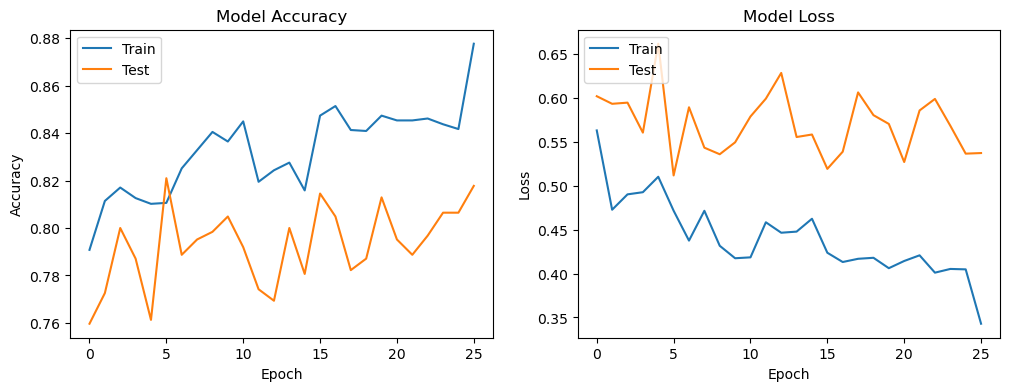

In [52]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(final_history_sparse.history['accuracy'])
plt.plot(final_history_sparse.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(final_history_sparse.history['loss'])
plt.plot(final_history_sparse.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

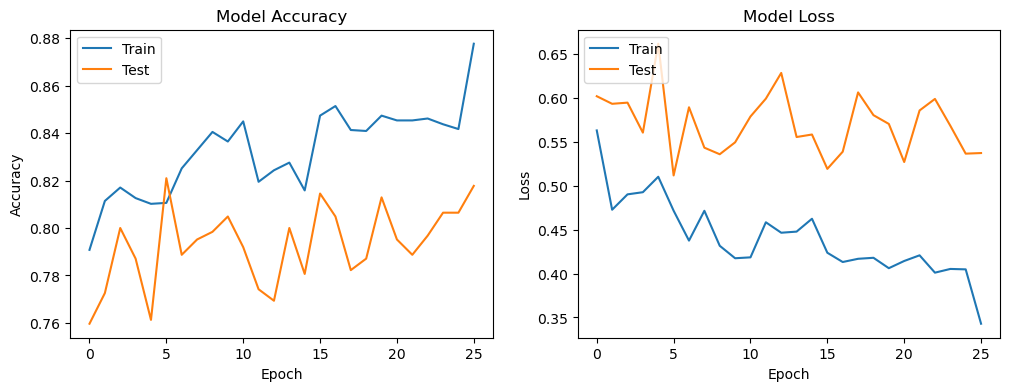

In [55]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(final_history_sparse.history['accuracy'])
plt.plot(final_history_sparse.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(final_history_sparse.history['loss'])
plt.plot(final_history_sparse.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [54]:
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout


y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)


final_model_CC = Sequential()
final_model_CC.add(Dense(600, input_shape=(675,), activation='relu'))
final_model_CC.add(Dropout(.2))
final_model_CC.add(Dense(300, activation='relu'))
final_model_CC.add(Dropout(.2))
final_model_CC.add(Dense(150, activation='relu'))
final_model_CC.add(Dense(75, activation='relu'))
final_model_CC.add(Dropout(.2))
final_model_CC.add(Dense(4, activation='softmax'))


final_model_CC.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint('final_model.h5', monitor='accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')


final_model_CC.fit(X_train, y_train_cat, epochs=100, validation_data=(X_test, y_test_cat), callbacks=[checkpoint, early_stop])


y_preds = final_model_CC.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1) # Convert back to class labels for evaluation
print(classification_report(y_test_labels, class_predictions))


Epoch 1/100
78/78 [==============================] - 1s 8ms/step - loss: 1.3346 - accuracy: 0.3485 - val_loss: 1.2418 - val_accuracy: 0.4774
Epoch 2/100
31/78 [==========>...................] - ETA: 0s - loss: 1.2604 - accuracy: 0.3992

C:\Users\mainf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 0s 6ms/step - loss: 1.2017 - accuracy: 0.4394 - val_loss: 1.0701 - val_accuracy: 0.5323
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 1.1080 - accuracy: 0.4988 - val_loss: 1.0657 - val_accuracy: 0.5113
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 1.0474 - accuracy: 0.5343 - val_loss: 0.9550 - val_accuracy: 0.6065
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9921 - accuracy: 0.5666 - val_loss: 0.9031 - val_accuracy: 0.6403
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9574 - accuracy: 0.5929 - val_loss: 0.8750 - val_accuracy: 0.6242
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.9109 - accuracy: 0.6143 - val_loss: 0.9085 - val_accuracy: 0.6032
Epoch 8/100
78/78 [==============================] - 0s 6ms/step - loss: 0.8885 - accuracy: 0.6296 - val_loss: 0.8875 - val_accuracy: 0.6468
Epoch 9/100
78/78 [======

Epoch 60/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4365 - accuracy: 0.8316 - val_loss: 0.5148 - val_accuracy: 0.8194
Epoch 61/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4355 - accuracy: 0.8267 - val_loss: 0.6131 - val_accuracy: 0.7774
Epoch 62/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4432 - accuracy: 0.8332 - val_loss: 0.5209 - val_accuracy: 0.8210
Epoch 63/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4350 - accuracy: 0.8380 - val_loss: 0.5511 - val_accuracy: 0.8065
Epoch 64/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4731 - accuracy: 0.8154 - val_loss: 0.5235 - val_accuracy: 0.8016
Epoch 65/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4246 - accuracy: 0.8421 - val_loss: 0.5049 - val_accuracy: 0.8097
Epoch 66/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4173 - accuracy: 0.8421 - val_loss: 0.5255 - val_accuracy: 0.8161
Epoch 

In [57]:
final_model = Sequential()
final_model.add(Dense(600, input_shape=(675,), activation='relu'))
final_model.add(Dense(300, activation='relu'))
final_model.add(Dense(150, activation='relu'))
final_model.add(Dense(75, activation='relu'))
final_model.add(Dense(4, activation='softmax'))

final_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
final_model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))
final_history = final_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

y_preds = final_model.predict(X_test)
class_predictions = np.argmax(y_preds, axis=1)
print(classification_report(y_test,class_predictions))

Epoch 1/200
78/78 [==============================] - 1s 7ms/step - loss: 1.2579 - accuracy: 0.4083 - val_loss: 1.2108 - val_accuracy: 0.3371
Epoch 2/200
78/78 [==============================] - 0s 6ms/step - loss: 1.0958 - accuracy: 0.4996 - val_loss: 0.9648 - val_accuracy: 0.5806
Epoch 3/200
78/78 [==============================] - 0s 5ms/step - loss: 0.9723 - accuracy: 0.5812 - val_loss: 0.9129 - val_accuracy: 0.6000
Epoch 4/200
78/78 [==============================] - 0s 5ms/step - loss: 0.8977 - accuracy: 0.6220 - val_loss: 0.9625 - val_accuracy: 0.5952
Epoch 5/200
78/78 [==============================] - 0s 5ms/step - loss: 0.8868 - accuracy: 0.6292 - val_loss: 0.8659 - val_accuracy: 0.6694
Epoch 6/200
78/78 [==============================] - 0s 5ms/step - loss: 0.8490 - accuracy: 0.6527 - val_loss: 0.7942 - val_accuracy: 0.7000
Epoch 7/200
78/78 [==============================] - 0s 5ms/step - loss: 0.8167 - accuracy: 0.6543 - val_loss: 0.7989 - val_accuracy: 0.6774
Epoch 8/200
7

Epoch 59/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0940 - accuracy: 0.9661 - val_loss: 1.1706 - val_accuracy: 0.7532
Epoch 60/200
78/78 [==============================] - 0s 6ms/step - loss: 0.1676 - accuracy: 0.9354 - val_loss: 0.5805 - val_accuracy: 0.8532
Epoch 61/200
78/78 [==============================] - 0s 5ms/step - loss: 0.1274 - accuracy: 0.9560 - val_loss: 0.6400 - val_accuracy: 0.8419
Epoch 62/200
78/78 [==============================] - 0s 5ms/step - loss: 0.1235 - accuracy: 0.9580 - val_loss: 0.6240 - val_accuracy: 0.8581
Epoch 63/200
78/78 [==============================] - 0s 5ms/step - loss: 0.1769 - accuracy: 0.9463 - val_loss: 0.6961 - val_accuracy: 0.8097
Epoch 64/200
78/78 [==============================] - 0s 5ms/step - loss: 0.2220 - accuracy: 0.9212 - val_loss: 0.5175 - val_accuracy: 0.8500
Epoch 65/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0786 - accuracy: 0.9725 - val_loss: 0.5832 - val_accuracy: 0.8403
Epoch 

78/78 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 0.9980 - val_loss: 0.8354 - val_accuracy: 0.8742
Epoch 117/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.8550 - val_accuracy: 0.8694
Epoch 118/200
78/78 [==============================] - 0s 5ms/step - loss: 0.2823 - accuracy: 0.9261 - val_loss: 1.3931 - val_accuracy: 0.6968
Epoch 119/200
78/78 [==============================] - 0s 5ms/step - loss: 0.2874 - accuracy: 0.9039 - val_loss: 0.5512 - val_accuracy: 0.8355
Epoch 120/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0577 - accuracy: 0.9798 - val_loss: 0.6833 - val_accuracy: 0.8387
Epoch 121/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0685 - accuracy: 0.9770 - val_loss: 1.3118 - val_accuracy: 0.8210
Epoch 122/200
78/78 [==============================] - 0s 5ms/step - loss: 0.2367 - accuracy: 0.9410 - val_loss: 0.6340 - val_accuracy: 0.8484
Epoch 123/200

78/78 [==============================] - 0s 5ms/step - loss: 0.0545 - accuracy: 0.9778 - val_loss: 0.6961 - val_accuracy: 0.8742
Epoch 174/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0837 - accuracy: 0.9701 - val_loss: 0.8919 - val_accuracy: 0.8452
Epoch 175/200
78/78 [==============================] - 0s 5ms/step - loss: 0.1011 - accuracy: 0.9649 - val_loss: 1.0309 - val_accuracy: 0.8048
Epoch 176/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0506 - accuracy: 0.9810 - val_loss: 0.6506 - val_accuracy: 0.8694
Epoch 177/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0406 - accuracy: 0.9847 - val_loss: 0.6660 - val_accuracy: 0.8468
Epoch 178/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0297 - accuracy: 0.9875 - val_loss: 0.7755 - val_accuracy: 0.8403
Epoch 179/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.7794 - val_accuracy: 0.8629
Epoch 180/200

78/78 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.8668 - val_accuracy: 0.8742
Epoch 31/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9984 - val_loss: 0.8911 - val_accuracy: 0.8645
Epoch 32/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.8961 - val_accuracy: 0.8710
Epoch 33/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 0.9187 - val_accuracy: 0.8694
Epoch 34/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.9988 - val_loss: 0.9238 - val_accuracy: 0.8726
Epoch 35/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.9427 - val_accuracy: 0.8677
Epoch 36/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.9659 - val_accuracy: 0.8677
Epoch 37/100
78/78 

Epoch 88/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 1.0109 - val_accuracy: 0.8694
Epoch 89/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.9992 - val_loss: 1.0510 - val_accuracy: 0.8629
Epoch 90/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 0.9988 - val_loss: 1.0375 - val_accuracy: 0.8694
Epoch 91/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 0.9988 - val_loss: 1.0283 - val_accuracy: 0.8710
Epoch 92/100
78/78 [==============================] - 0s 5ms/step - loss: 0.2216 - accuracy: 0.9426 - val_loss: 0.9075 - val_accuracy: 0.7484
Epoch 93/100
78/78 [==============================] - 0s 5ms/step - loss: 0.2638 - accuracy: 0.9103 - val_loss: 0.6104 - val_accuracy: 0.8629
Epoch 94/100
78/78 [==============================] - 0s 5ms/step - loss: 0.0632 - accuracy: 0.9790 - val_loss: 0.7751 - val_accuracy: 0.8306
Epoch 

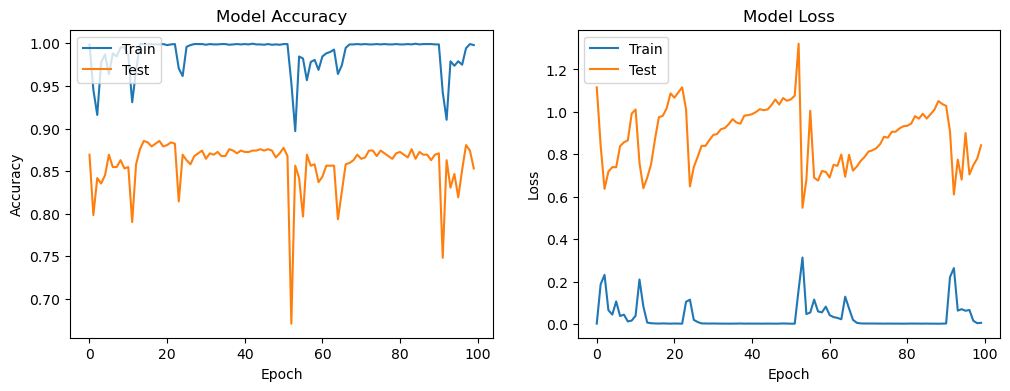

In [58]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'])
plt.plot(final_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()